##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Text classification with TensorFlow Hub: Movie reviews

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?module-type=text-embedding"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

The tutorial demonstrates the basic application of transfer learning with [TensorFlow Hub](https://tfhub.dev) and Keras.

It uses the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

This notebook uses [`tf.keras`](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow, and [`tensorflow_hub`](https://www.tensorflow.org/hub), a library for loading trained models from [TFHub](https://tfhub.dev) in a single line of code. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-datasets
!pip install tf-keras

In [ ]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tf_keras as keras

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

## Download the IMDB dataset

The IMDB dataset is available on [imdb reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) or on [TensorFlow datasets](https://www.tensorflow.org/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [ ]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

## Explore the data

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Let's print first 10 examples.

In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

Let's also print the first 10 labels.

In [ ]:
train_labels_batch

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. Use a pre-trained text embedding as the first layer, which will have three advantages:

*   You don't have to worry about text preprocessing,
*   Benefit from transfer learning,
*   the embedding has a fixed size, so it's simpler to process.

For this example you use a **pre-trained text embedding model** from [TensorFlow Hub](https://tfhub.dev) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2).

There are many other pre-trained text embeddings from TFHub that can be used in this tutorial:

* [google/nnlm-en-dim128/2](https://tfhub.dev/google/nnlm-en-dim128/2) - trained with the same NNLM architecture on the same data as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with a larger embedding dimension. Larger dimensional embeddings can improve on your task but it may take longer to train your model.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - the same as [google/nnlm-en-dim128/2](https://tfhub.dev/google/nnlm-en-dim128/2), but with additional text normalization such as removing punctuation. This can help if the text in your task contains additional characters or punctuation.
* [google/universal-sentence-encoder/4](https://tfhub.dev/google/universal-sentence-encoder/4) - a much larger model yielding 512 dimensional embeddings trained with a deep averaging network (DAN) encoder.

And many more! Find more [text embedding models](https://tfhub.dev/s?module-type=text-embedding) on TFHub.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that no matter the length of the input text, the output shape of the embeddings is: `(num_examples, embedding_dimension)`.

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

Let's now build the full model:

In [ ]:
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1))

model.summary()

The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The pre-trained text embedding model that you are using ([google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`. For this NNLM model, the `embedding_dimension` is 50.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node.

Let's compile the model.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), you'll use the `binary_crossentropy` loss function.

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when you are exploring regression problems (say, to predict the price of a house), you'll see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [11]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Train the model for 10 epochs in mini-batches of 512 samples. This is 10 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [12]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 63s 2s/step - loss: 0.0297 - accuracy: 0.9961 - val_loss: 0.3692 - val_accuracy: 0.8689
Epoch 2/10
30/30 [==============================] - 47s 2s/step - loss: 0.0171 - accuracy: 0.9987 - val_loss: 0.3947 - val_accuracy: 0.8666
Epoch 3/10
30/30 [==============================] - 48s 2s/step - loss: 0.0108 - accuracy: 0.9995 - val_loss: 0.4188 - val_accuracy: 0.8675
Epoch 4/10
30/30 [==============================] - 50s 2s/step - loss: 0.0072 - accuracy: 0.9997 - val_loss: 0.4424 - val_accuracy: 0.8661
Epoch 5/10
30/30 [==============================] - 49s 2s/step - loss: 0.0051 - accuracy: 0.9998 - val_loss: 0.4633 - val_accuracy: 0.8652
Epoch 6/10
30/30 [==============================] - 47s 2s/step - loss: 0.0037 - accuracy: 0.9999 - val_loss: 0.4821 - val_accuracy: 0.8644
Epoch 7/10
30/30 [==============================] - 47s 2s/step - loss: 0.0028 - accuracy: 0.9999 - val_loss: 0.4990 - val_accuracy: 0.8647
Epoch 8/10
30/30 [==

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [13]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 12s - loss: 0.5890 - accuracy: 0.8440 - 12s/epoch - 235ms/step
loss: 0.589
accuracy: 0.844


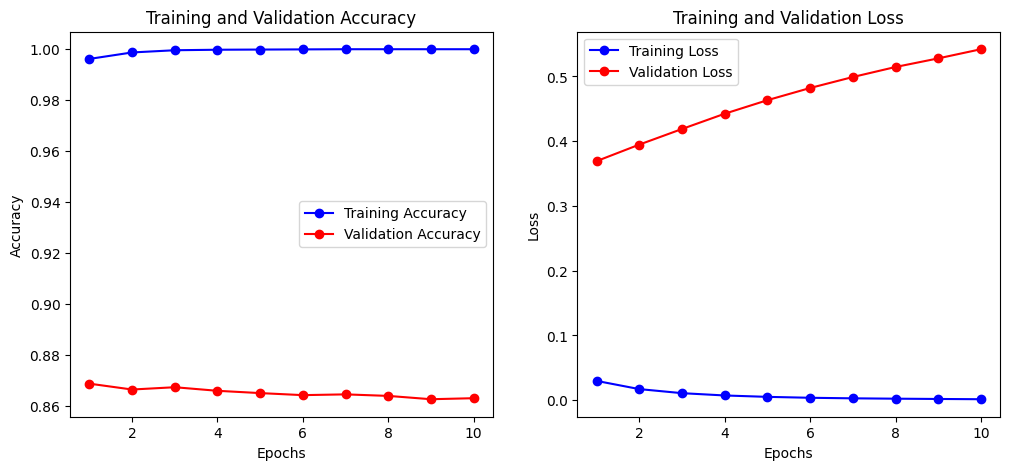

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

In [ ]:
from sklearn.metrics import classification_report

# Prepare test data
test_data_batch = test_data.batch(512)
y_true = []
y_pred = []

for batch_texts, batch_labels in test_data_batch:
    y_true.extend(batch_labels.numpy())  # Get true labels
    preds = model.predict(batch_texts)  # Predict
    y_pred.extend([1 if p > 0 else 0 for p in preds])  # Convert logits to binary labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

16/16 [==============================] - 4s 248ms/step


## Further reading

* For a more general way to work with string inputs and for a more detailed analysis of the progress of accuracy and loss during training, see the [Text classification with preprocessed text](./text_classification.ipynb) tutorial.
* Try out more [text-related tutorials](https://www.tensorflow.org/hub/tutorials#text-related-tutorials) using trained models from TFHub.